<a href="https://colab.research.google.com/github/maurojp/Pareto_Optimizer/blob/main/Pareto_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparamos el entorno**

In [ ]:
"""

  Optimizador de modelos neuronales mediante Optimalidad de Pareto
  Autor: maurojp

"""

try:
  # El comando %tensorflow_version solo existe en Colaboratory. Es un MAGIC COMMAND.
  %tensorflow_version 2.x
except Exception:
  pass

import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

**Aquí comienza el código de la herramienta Pareto_Optimizer**

In [ ]:
"""

  El argumento hps_list es un numpy.array de listas que representa en primer orden
  el hiperparametro y en segundo orden (la lista) los valores que va a tomar el 
  hiperparametro en el proceso de optimización.
  Ej:
  hps_list = np.array([[1, 2, 3], [10, 20]]) 
  En este ejemplo hay dos hiperparametros que variaran durante el proceso,
  el primero tomara los valores 1, 2, 3 y el segundo 10, 20.

  Retorna un numpy.array de dimensiones:
  (cantidad de experimentos, cantidad de hiperparametros)
  con todas las combinaciones posibles de hiperparametros.

"""

def exps_composer(hps_list):

  # Calculo del total de experimentos a crear
  total_exps_size = 1
  for l in hps_list:
    total_exps_size *= len(l)

  # Matriz de experimentos con todas la combinaciones de hiperparametros
  exps = np.zeros((hps_list.shape[0], total_exps_size))

  # Creación de las combinaciones de hiperparametros
  segment_num = 0
  for i in range(exps.shape[0]):
    if (i > 0):
      segment = int(exps.shape[1]/(segment_num * len(hps_list[i])))
      start = 0
      for j in range(segment_num):
        for k in range(len(hps_list[i])):
          exps[i][start:start+segment] = hps_list[i][k]
          start += segment
      segment_num = segment_num * len(hps_list[i])
    else:
      segment = int(exps.shape[1]/len(hps_list[i]))
      start = 0
      for j in range(len(hps_list[i])):
        exps[i][start:start+segment] = hps_list[i][j]
        start += segment
      segment_num = len(hps_list[i])

  return np.transpose(exps)

In [ ]:
# Evalua el tiempo de predicción promediando entre 10 predicciones.

def evaluate_time(hps, X_train, y_train, X_test, y_test, X_val, y_val):
  model = build_model(hps)
  start = time.time()
  for i in range(10):
    preds = model.predict(X_val, verbose=0)
  end = time.time()
  delay = (end - start)/10
  print('Tiempo promedio de predicción:', delay)
  return delay

In [ ]:
# Evalua el error de la predicción (1 - Accuracy).

def evaluate_error(hps, X_train, y_train, X_test, y_test, X_val, y_val):
  batch_size = 128
  epochs = 2 # Para reducir el tiempo de corrida del ejemplo
  model = build_model(hps)
  model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose=0, validation_data = (X_val, y_val))
  loss, score = model.evaluate(X_test, y_test)
  print('Error: ', 1 - score)
  return 1 - score

In [ ]:
"""

  Esta función recibe como parametros los pares x,y,l donde l es la etiqueta
  para identificar el experimento productor del par x,y. Devuelve una lista con 
  los datos de los puntos que pertenecen a la frontera de Pareto.

"""

def pareto_frontier(Xs, Ys, Ls):
  paretoList = sorted([[Xs[i], Ys[i], Ls[i]] for i in range(len(Xs))], reverse=False)
  p_front = [paretoList[0]]    
  for pair in paretoList[1:]:
    if pair[1] <= p_front[-1][1]:
      p_front.append(pair)
  p_frontX = [pair[0] for pair in p_front]
  p_frontY = [pair[1] for pair in p_front]
  p_frontL = [pair[2] for pair in p_front]
  return p_frontX, p_frontY, p_frontL

In [ ]:
"""

  Evalua todos los experimentos y devuelve una array con los resultados de
  error, tiempo y el indice.

"""

def evaluate_exps(exps, X_train, y_train, X_test, y_test, X_val, y_val):
  return np.array([[evaluate_time(hps, X_train, y_train, X_test, y_test, X_val, y_val) for hps in exps], [evaluate_error(hps, X_train, y_train, X_test, y_test, X_val, y_val) for hps in exps], [index for index in range(exps.shape[0])]])

In [ ]:
"""

  Grafica la dispersión de los resultados y la frontera de Pareto.

"""

def pareto_plot(all_results, pareto_f):
  plt.figure(figsize=(16,10), facecolor='white')
  plt.scatter(all_results[0], all_results[1], s = 200, alpha=0.5)
  plt.plot(pareto_f[0], pareto_f[1], label = 'Frontera de Pareto', color = 'red', linewidth=4, markersize=30 )
  for a,b,c in zip(pareto_f[0], pareto_f[1], pareto_f[2]): 
      plt.text(a, b, str(int(c)), fontsize=20)
  plt.legend(loc = 'upper right')
  plt.xlabel("Tiempo", fontsize=20)
  plt.ylabel("Error", fontsize=20)
  plt.title('Resultados de los Experimentos', fontsize=20)
  plt.grid(True)
  plt.show()

In [ ]:
"""

  Genera los experimentos, los corre y muestra los resultados.
  Solo recibe como argumento la lista de hiperparametros con sus variaciones y
  el Dataset particionado. Al modelo lo toma de la función build_model.

"""

def pareto_optimizer(hps_list, X_train, y_train, X_test, y_test, X_val, y_val):
  # Genera los experimentos a partir de los hiperparametros
  print("Generando experimentos...")
  exps = exps_composer(hps_list)
  # Evalua el modelo con todos las combinaciones de hiperparametros (experimentos).
  print("Evaluando ", int(exps.shape[0]), " experimentos...")
  all_results = evaluate_exps(exps, X_train, y_train, X_test, y_test, X_val, y_val)
  # Salecciona los experimentos que se encuentran en la frontera de Pareto.
  pareto_f = pareto_frontier(all_results[0], all_results[1], all_results[2])
  # Muestra los resultados.
  pareto_plot(all_results, pareto_f)
  # Lista de los experimentos en la frontera de Pareto.
  print("Valores de los hiperparametros en los experimentos de la Frontera de Pareto")
  for x in pareto_f[2]:
    print("Experimento: ", int(x), " Hiperparametros: ", exps[int(x)])

**Una vez cargadas todas las funciones necesarias, vemos un ejemplo de uso con el dataset MNIST**

* Paso 1: Definimos el modelo en una función llamada *build_model* donde hps es la lista con los valores de los hiperparametros para los experimentos.

In [ ]:
"""

  Necesitamos definir el modelo dentro de esta función (con este nombre),
  donde ademas vinculamos los valores de la lista hps con el hiperparametro
  que representa. Para este ejemplo relacionamos los elementos de la lista hps
  de la siguiente forma:
  hps[0] tamaño del kernel 1
  hps[1] la cantidad de filtros de la capa convolucional 1
  hps[2] tamaño del kernel 2
  hps[3] la cantidad de filtros de la capa convolucional 2
  hps[4] la tasa de la capa dropout
  Pueden probarse variaciones de más hiperparametros, hay que tener en cuenta
  que se incrementará el tiempo de computo por cada hiperparametro que variemos.

"""

def build_model(hps):
  input_shape = (28, 28, 1)
  kernel1_size = int(hps[0])
  kernel1_num = int(hps[1])
  kernel2_size = int(hps[2])
  kernel2_num = int(hps[3])
  drop_out_perc = hps[4]
  model = keras.Sequential()
  model.add(keras.Input(shape=input_shape))
  model.add(layers.Conv2D(kernel1_num, kernel_size=(kernel1_size, kernel1_size), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(kernel2_num, kernel_size=(kernel2_size, kernel2_size), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(drop_out_perc))
  model.add(layers.Dense(10, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # print(model_m.summary())
  return model

* Paso 2: Defimos un numpy array con un elemento por cada hiperparametro a probar, que a la vez es una lista de valores para ese hiperparametro.

In [ ]:
"""

Cargamos en un Numpy array los hiperparametros y los valores a probar, en este
ejemplo se expresan así:

hps_list[0] puede tomar valores 3. (Tamaño de kernel 1)
hps_list[1] puede tomar valores 8, 16, 32. (Filtros en capa conv. 1)
hps_list[2] puede tomar valores 2,3. (Tamaño de kernel 2)
hps_list[3] puede tomar valores 32, 64. (Filtros en capa conv. 2)
hps_list[4] puede tomar valores .5. (Tasa de Dropout)

Si analizamos nuestros modelos podemos ver que algunos hiperparametros al variar
incrementaran el tiempo de predicción ya que agregan calculos, mientras que
otros solo afectarán el error.

"""
hps_list = np.array([[3], [8, 16, 32], [2, 3], [32, 64], [.5]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


* Paso 3: Solo nos resta preparar el Dataset con una fracción de entrenamiento, otra de validación y una de test, y correr el código!!!

Generando experimentos...
Evaluando  12  experimentos...
Tiempo promedio de prediccion: 1.6042303085327148
Tiempo promedio de prediccion: 1.8302582025527954
Tiempo promedio de prediccion: 1.6657743215560914
Tiempo promedio de prediccion: 1.8296376943588257
Tiempo promedio de prediccion: 1.852253007888794
Tiempo promedio de prediccion: 1.982107925415039
Tiempo promedio de prediccion: 1.8648272514343263
Tiempo promedio de prediccion: 2.188537335395813
Tiempo promedio de prediccion: 2.114001226425171
Tiempo promedio de prediccion: 2.388027548789978
Tiempo promedio de prediccion: 2.3024861097335814
Tiempo promedio de prediccion: 2.7687589168548583
313/313 [==============================] - 2s 5ms/step - loss: 0.1171 - accuracy: 0.9660
Error:  0.0339999794960022
313/313 [==============================] - 2s 6ms/step - loss: 0.0858 - accuracy: 0.9746
Error:  0.025399982929229736
313/313 [==============================] - 2s 5ms/step - loss: 0.0971 - accuracy: 0.9714
Error:  0.028599977493286

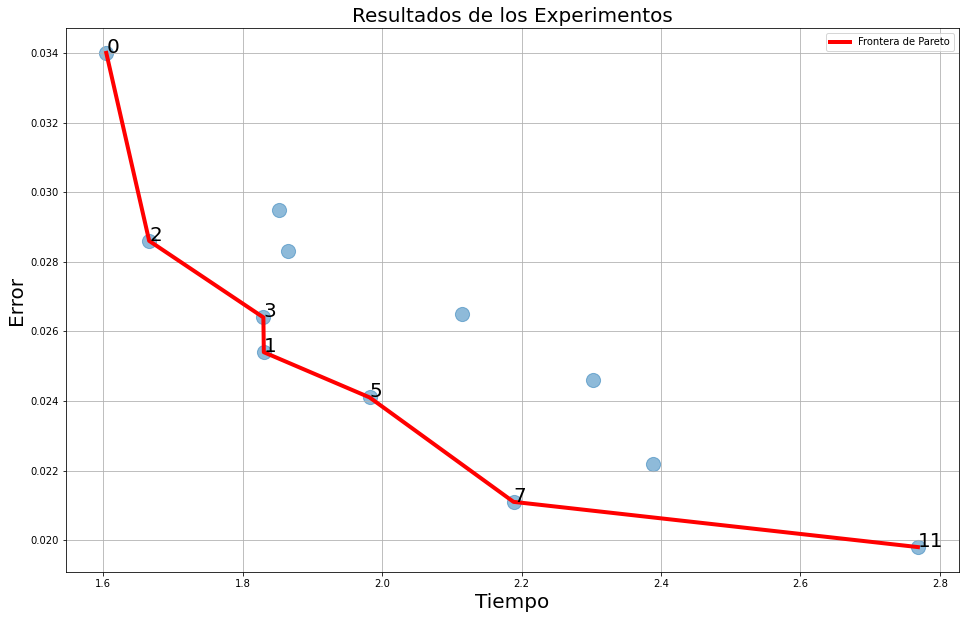

Valores de los hiperparametros en los experimentos de la Frontera de Pareto
Experimento:  0  Hiperparametros:  [ 3.   8.   2.  32.   0.5]
Experimento:  2  Hiperparametros:  [ 3.   8.   3.  32.   0.5]
Experimento:  3  Hiperparametros:  [ 3.   8.   3.  64.   0.5]
Experimento:  1  Hiperparametros:  [ 3.   8.   2.  64.   0.5]
Experimento:  5  Hiperparametros:  [ 3.  16.   2.  64.   0.5]
Experimento:  7  Hiperparametros:  [ 3.  16.   3.  64.   0.5]
Experimento:  11  Hiperparametros:  [ 3.  32.   3.  64.   0.5]


In [ ]:
"""

  Preparación del Dataset y ejecución del método
  
"""

# Descargamos el dataset partido en dos para entrenamiento y test
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalizamos los valores entre 0 y 1
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Adaptamos la forma de entrada para el modelo
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Extraemos el 20% del conjunto de entrenamiento para validar
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Utilizamos codificación One-hot para las etiquetas de salida esperada
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Corremos el optimizador
pareto_optimizer(hps_list, X_train, y_train, X_test, y_test, X_val, y_val)